### Setup

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "autoencoders"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

No GPU was detected. LSTMs and CNNs can be very slow without a GPU.


In [2]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

### PCA with a linear Autoencoder

In [3]:

np.random.seed(4)

def generate_3d_data(m, w1=0.1, w2=0.3, noise=0.1):
    angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
    data = np.empty((m, 3))
    data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
    data[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
    data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * np.random.randn(m)
    return data

X_train = generate_3d_data(60)
X_train = X_train - X_train.mean(axis=0, keepdims=0)

In [4]:
np.random.seed(42)
tf.random.set_seed(42)

encoder = keras.models.Sequential([keras.layers.Dense(2, input_shape=[3])])
decoder = keras.models.Sequential([keras.layers.Dense(3, input_shape=[2])])
autoencoder = keras.models.Sequential([encoder, decoder])

autoencoder.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1.5))

In [5]:
history = autoencoder.fit(X_train, X_train, epochs=20)

Train on 60 samples
Epoch 1/20
60/60 [==============================] - 0s 4ms/sample - loss: 0.3064
Epoch 2/20
60/60 [==============================] - 0s 73us/sample - loss: 0.3797
Epoch 3/20
60/60 [==============================] - 0s 56us/sample - loss: 0.1454
Epoch 4/20
60/60 [==============================] - 0s 66us/sample - loss: 0.0872
Epoch 5/20
60/60 [==============================] - 0s 48us/sample - loss: 0.0658
Epoch 6/20
60/60 [==============================] - 0s 65us/sample - loss: 0.0464
Epoch 7/20
60/60 [==============================] - 0s 73us/sample - loss: 0.0356
Epoch 8/20
60/60 [==============================] - 0s 50us/sample - loss: 0.0238
Epoch 9/20
60/60 [==============================] - 0s 48us/sample - loss: 0.0225
Epoch 10/20
60/60 [==============================] - 0s 66us/sample - loss: 0.0093
Epoch 11/20
60/60 [==============================] - 0s 75us/sample - loss: 0.0068
Epoch 12/20
60/60 [==============================] - 0s 73us/sample - loss: 0

In [6]:
codings = encoder.predict(X_train)

Saving figure linear_autoencoder_pca_plot


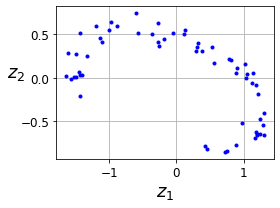

In [7]:
fig = plt.figure(figsize=(4,3))
plt.plot(codings[:,0], codings[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)
save_fig("linear_autoencoder_pca_plot")
plt.show()

### Stacked Autoencoders

In [8]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

### Train all layers at once

In [9]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [10]:
tf.random.set_seed(42)
np.random.seed(42)

stacked_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu"),
])
stacked_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])
stacked_ae.compile(loss="binary_crossentropy",
                   optimizer=keras.optimizers.SGD(lr=1.5), metrics=[rounded_accuracy])
history = stacked_ae.fit(X_train, X_train, epochs=20,
                         validation_data=(X_valid, X_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/20
55000/55000 [==============================] - 5s 88us/sample - loss: 0.3390 - rounded_accuracy: 0.8860 - val_loss: 0.3111 - val_rounded_accuracy: 0.9129
Epoch 2/20
55000/55000 [==============================] - 5s 83us/sample - loss: 0.3059 - rounded_accuracy: 0.9149 - val_loss: 0.3048 - val_rounded_accuracy: 0.9201
Epoch 3/20
55000/55000 [==============================] - 4s 69us/sample - loss: 0.2989 - rounded_accuracy: 0.9212 - val_loss: 0.3033 - val_rounded_accuracy: 0.9120
Epoch 4/20
55000/55000 [==============================] - 4s 72us/sample - loss: 0.2950 - rounded_accuracy: 0.9246 - val_loss: 0.2944 - val_rounded_accuracy: 0.9277
Epoch 5/20
55000/55000 [==============================] - 4s 76us/sample - loss: 0.2924 - rounded_accuracy: 0.9268 - val_loss: 0.2923 - val_rounded_accuracy: 0.9280
Epoch 6/20
55000/55000 [==============================] - 4s 71us/sample - loss: 0.2908 - rounded_accuracy: 0.9280 - val_loss:

In [11]:
def show_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

Saving figure reconstruction_plot


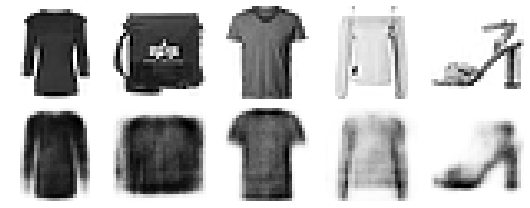

In [12]:
show_reconstructions(stacked_ae)
save_fig("reconstruction_plot")

### Visualizing Fashion MNIST

In [13]:
np.random.seed(42)

from sklearn.manifold import TSNE

X_valid_compressed = stacked_encoder.predict(X_valid)
tsne = TSNE()
X_valid_2D = tsne.fit_transform(X_valid_compressed)
X_valid_2D = (X_valid_2D - X_valid_2D.min()) / (X_valid_2D.max() - X_valid_2D.min())

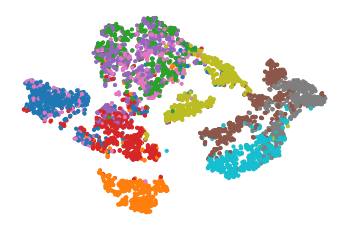

In [14]:
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap="tab10")
plt.axis("off")
plt.show()

Saving figure fashion_mnist_visualization_plot


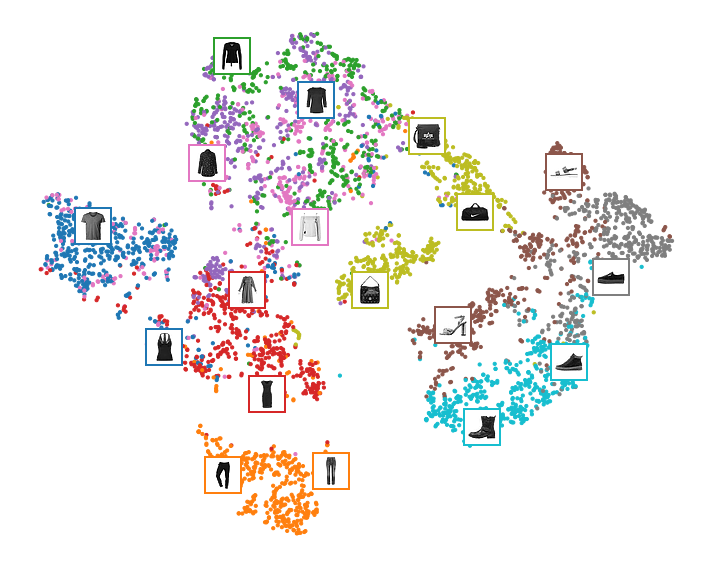

In [15]:
plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(X_valid_2D):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(X_valid[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_valid[index]), "lw": 2})
        plt.gca().add_artist(imagebox)
plt.axis("off")
save_fig("fashion_mnist_visualization_plot")
plt.show()

### Tying weights

In [16]:
class DenseTranspose(keras.layers.Layer):
    def __init__(self, dense, activation=None, **kwargs):
        self.dense = dense
        self.activation = keras.activations.get(activation)
        super().__init__(**kwargs)
    def build(self, batch_input_shape):
        self.biases = self.add_weight(name="bias",
                                      shape=[self.dense.input_shape[-1]],
                                      initializer="zeros")
        super().build(batch_input_shape)
    def call(self, inputs):
        z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True)
        return self.activation(z + self.biases)

In [17]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

dense_1 = keras.layers.Dense(100, activation="selu")
dense_2 = keras.layers.Dense(30, activation="selu")

tied_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    dense_1,
    dense_2
])

tied_decoder = keras.models.Sequential([
    DenseTranspose(dense_2, activation="selu"),
    DenseTranspose(dense_1, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

tied_ae = keras.models.Sequential([tied_encoder, tied_decoder])

tied_ae.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.SGD(lr=1.5), metrics=[rounded_accuracy])
history = tied_ae.fit(X_train, X_train, epochs=10,
                      validation_data=(X_valid, X_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 5s 84us/sample - loss: 0.3268 - rounded_accuracy: 0.8960 - val_loss: 0.3024 - val_rounded_accuracy: 0.9207
Epoch 2/10
55000/55000 [==============================] - 4s 70us/sample - loss: 0.2974 - rounded_accuracy: 0.9225 - val_loss: 0.2974 - val_rounded_accuracy: 0.9271
Epoch 3/10
55000/55000 [==============================] - 4s 68us/sample - loss: 0.2918 - rounded_accuracy: 0.9277 - val_loss: 0.2961 - val_rounded_accuracy: 0.9265
Epoch 4/10
55000/55000 [==============================] - 4s 72us/sample - loss: 0.2889 - rounded_accuracy: 0.9303 - val_loss: 0.2899 - val_rounded_accuracy: 0.9321
Epoch 5/10
55000/55000 [==============================] - 4s 81us/sample - loss: 0.2867 - rounded_accuracy: 0.9322 - val_loss: 0.2867 - val_rounded_accuracy: 0.9338
Epoch 6/10
55000/55000 [==============================] - 4s 72us/sample - loss: 0.2851 - rounded_accuracy: 0.9337 - val_loss:

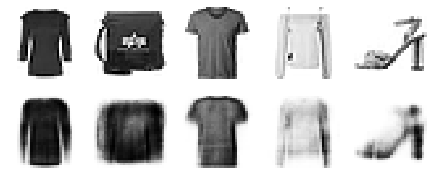

In [18]:
show_reconstructions(tied_ae)
plt.show()

### Training one Autoencoder at a Time

In [19]:
def train_autoencoder(n_neurons, X_train, X_valid, loss, optimizer,
                      n_epochs=10, output_activation=None, metrics=None):
    n_inputs = X_train.shape[-1]
    encoder = keras.models.Sequential([
        keras.layers.Dense(n_neurons, activation="selu", input_shape=[n_inputs])
    ])
    decoder = keras.models.Sequential([
        keras.layers.Dense(n_inputs, activation=output_activation),
    ])
    autoencoder = keras.models.Sequential([encoder, decoder])
    autoencoder.compile(optimizer, loss, metrics=metrics)
    autoencoder.fit(X_train, X_train, epochs=n_epochs,
                    validation_data=(X_valid, X_valid))
    return encoder, decoder, encoder(X_train), encoder(X_valid)

In [20]:
tf.random.set_seed(42)
np.random.seed(42)

K = keras.backend
X_train_flat = K.batch_flatten(X_train) # equivalent to .reshape(-1, 28 * 28)
X_valid_flat = K.batch_flatten(X_valid)
enc1, dec1, X_train_enc1, X_valid_enc1 = train_autoencoder(
    100, X_train_flat, X_valid_flat, "binary_crossentropy",
    keras.optimizers.SGD(lr=1.5), output_activation="sigmoid",
    metrics=[rounded_accuracy])
enc2, dec2, _, _ = train_autoencoder(
    30, X_train_enc1, X_valid_enc1, "mse", keras.optimizers.SGD(lr=0.05),
    output_activation="selu")

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 4s 67us/sample - loss: 0.3446 - rounded_accuracy: 0.8873 - val_loss: 0.3123 - val_rounded_accuracy: 0.9148
Epoch 2/10
55000/55000 [==============================] - 4s 67us/sample - loss: 0.3040 - rounded_accuracy: 0.9202 - val_loss: 0.3008 - val_rounded_accuracy: 0.9248
Epoch 3/10
55000/55000 [==============================] - 3s 61us/sample - loss: 0.2951 - rounded_accuracy: 0.9284 - val_loss: 0.2936 - val_rounded_accuracy: 0.9314
Epoch 4/10
55000/55000 [==============================] - 4s 65us/sample - loss: 0.2893 - rounded_accuracy: 0.9340 - val_loss: 0.2889 - val_rounded_accuracy: 0.9357
Epoch 5/10
55000/55000 [==============================] - 4s 65us/sample - loss: 0.2855 - rounded_accuracy: 0.9376 - val_loss: 0.2859 - val_rounded_accuracy: 0.9387
Epoch 6/10
55000/55000 [==============================] - 3s 61us/sample - loss: 0.2829 - rounded_accuracy: 0.9401 - val_loss:

In [21]:
stacked_ae_1_by_1 = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    enc1, enc2, dec2, dec1,
    keras.layers.Reshape([28, 28])
])

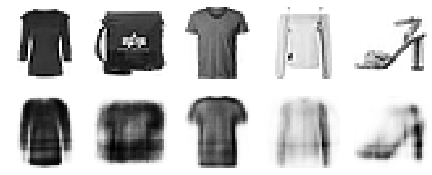

In [22]:
show_reconstructions(stacked_ae_1_by_1)
plt.show()

In [23]:
stacked_ae_1_by_1.compile(loss="binary_crossentropy",
                          optimizer=keras.optimizers.SGD(lr=0.1), metrics=[rounded_accuracy])
history = stacked_ae_1_by_1.fit(X_train, X_train, epochs=10,
                                validation_data=(X_valid, X_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 4s 76us/sample - loss: 0.2847 - rounded_accuracy: 0.9366 - val_loss: 0.2863 - val_rounded_accuracy: 0.9366
Epoch 2/10
55000/55000 [==============================] - 4s 75us/sample - loss: 0.2844 - rounded_accuracy: 0.9369 - val_loss: 0.2861 - val_rounded_accuracy: 0.9369
Epoch 3/10
55000/55000 [==============================] - 4s 73us/sample - loss: 0.2842 - rounded_accuracy: 0.9371 - val_loss: 0.2859 - val_rounded_accuracy: 0.9370
Epoch 4/10
55000/55000 [==============================] - 4s 80us/sample - loss: 0.2840 - rounded_accuracy: 0.9373 - val_loss: 0.2858 - val_rounded_accuracy: 0.9370
Epoch 5/10
55000/55000 [==============================] - 4s 73us/sample - loss: 0.2839 - rounded_accuracy: 0.9374 - val_loss: 0.2857 - val_rounded_accuracy: 0.9373
Epoch 6/10
55000/55000 [==============================] - 4s 79us/sample - loss: 0.2838 - rounded_accuracy: 0.9375 - val_loss:

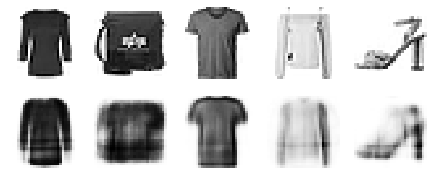

In [24]:
show_reconstructions(stacked_ae_1_by_1)
plt.show()

### Using Convolutional Layers Instead of Dense Layers

In [25]:
tf.random.set_seed(42)
np.random.seed(42)

conv_encoder = keras.models.Sequential([
    keras.layers.Reshape([28, 28, 1], input_shape=[28, 28]),
    keras.layers.Conv2D(16, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(64, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2)
])
conv_decoder = keras.models.Sequential([
    keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding="VALID", activation="selu",
                                 input_shape=[3, 3, 64]),
    keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding="SAME", activation="selu"),
    keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding="SAME", activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
conv_ae = keras.models.Sequential([conv_encoder, conv_decoder])

conv_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0),
                metrics=[rounded_accuracy])
history = conv_ae.fit(X_train, X_train, epochs=5,
                      validation_data=(X_valid, X_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/5
55000/55000 [==============================] - 28s 512us/sample - loss: 0.3018 - rounded_accuracy: 0.9184 - val_loss: 0.2798 - val_rounded_accuracy: 0.9391
Epoch 2/5
55000/55000 [==============================] - 28s 502us/sample - loss: 0.2755 - rounded_accuracy: 0.9412 - val_loss: 0.2755 - val_rounded_accuracy: 0.9436
Epoch 3/5
55000/55000 [==============================] - 27s 495us/sample - loss: 0.2707 - rounded_accuracy: 0.9463 - val_loss: 0.2727 - val_rounded_accuracy: 0.9453
Epoch 4/5
55000/55000 [==============================] - 28s 507us/sample - loss: 0.2681 - rounded_accuracy: 0.9490 - val_loss: 0.2678 - val_rounded_accuracy: 0.9512
Epoch 5/5
55000/55000 [==============================] - 28s 517us/sample - loss: 0.2663 - rounded_accuracy: 0.9509 - val_loss: 0.2664 - val_rounded_accuracy: 0.9526


In [26]:
conv_encoder.summary()
conv_decoder.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 64)        

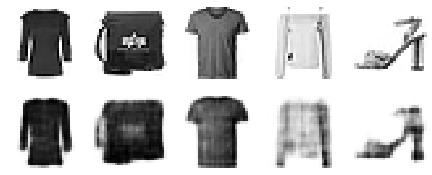

In [27]:
show_reconstructions(conv_ae)
plt.show()

### Recurrent Autoencoders¶

In [28]:
recurrent_encoder = keras.models.Sequential([
    keras.layers.LSTM(100, return_sequences=True, input_shape=[28, 28]),
    keras.layers.LSTM(30)
])
recurrent_decoder = keras.models.Sequential([
    keras.layers.RepeatVector(28, input_shape=[30]),
    keras.layers.LSTM(100, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(28, activation="sigmoid"))
])
recurrent_ae = keras.models.Sequential([recurrent_encoder, recurrent_decoder])
recurrent_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(0.1),
                     metrics=[rounded_accuracy])

In [29]:
history = recurrent_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 92s 2ms/sample - loss: 0.5191 - rounded_accuracy: 0.7484 - val_loss: 0.4583 - val_rounded_accuracy: 0.8129
Epoch 2/10
55000/55000 [==============================] - 85s 2ms/sample - loss: 0.4053 - rounded_accuracy: 0.8431 - val_loss: 0.3739 - val_rounded_accuracy: 0.8665
Epoch 3/10
55000/55000 [==============================] - 84s 2ms/sample - loss: 0.3656 - rounded_accuracy: 0.8708 - val_loss: 0.3583 - val_rounded_accuracy: 0.8788
Epoch 4/10
55000/55000 [==============================] - 85s 2ms/sample - loss: 0.3511 - rounded_accuracy: 0.8805 - val_loss: 0.3452 - val_rounded_accuracy: 0.8860
Epoch 5/10
55000/55000 [==============================] - 86s 2ms/sample - loss: 0.3407 - rounded_accuracy: 0.8872 - val_loss: 0.3377 - val_rounded_accuracy: 0.8864
Epoch 6/10
55000/55000 [==============================] - 83s 2ms/sample - loss: 0.3335 - rounded_accuracy: 0.8921 - val_loss:

KeyboardInterrupt: 

In [ ]:
show_reconstructions(recurrent_ae)
plt.show()

### Stacked denoising Autoencoder¶

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

denoising_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.GaussianNoise(0.2),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu")
])
denoising_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
denoising_ae = keras.models.Sequential([denoising_encoder, denoising_decoder])
denoising_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0),
                     metrics=[rounded_accuracy])
history = denoising_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid))

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

noise = keras.layers.GaussianNoise(0.2)
show_reconstructions(denoising_ae, noise(X_valid, training=True))
plt.show()

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

dropout_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu")
])
dropout_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
dropout_ae = keras.models.Sequential([dropout_encoder, dropout_decoder])
dropout_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0),
                   metrics=[rounded_accuracy])
history = dropout_ae.fit(X_train, X_train, epochs=10,
                         validation_data=(X_valid, X_valid))

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

dropout = keras.layers.Dropout(0.5)
show_reconstructions(dropout_ae, dropout(X_valid, training=True))
save_fig("dropout_denoising_plot", tight_layout=False)

### Sparse Autoencoder

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

simple_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="sigmoid"),
])
simple_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
simple_ae = keras.models.Sequential([simple_encoder, simple_decoder])
simple_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.),
                  metrics=[rounded_accuracy])
history = simple_ae.fit(X_train, X_train, epochs=10,
                        validation_data=(X_valid, X_valid))

In [ ]:
show_reconstructions(simple_ae)
plt.show()

In [ ]:
def plot_percent_hist(ax, data, bins):
    counts, _ = np.histogram(data, bins=bins)
    widths = bins[1:] - bins[:-1]
    x = bins[:-1] + widths / 2
    ax.bar(x, counts / len(data), width=widths*0.8)
    ax.xaxis.set_ticks(bins)
    ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(
        lambda y, position: "{}%".format(int(np.round(100 * y)))))
    ax.grid(True)

In [ ]:
def plot_activations_histogram(encoder, height=1, n_bins=10):
    X_valid_codings = encoder(X_valid).numpy()
    activation_means = X_valid_codings.mean(axis=0)
    mean = activation_means.mean()
    bins = np.linspace(0, 1, n_bins + 1)

    fig, [ax1, ax2] = plt.subplots(figsize=(10, 3), nrows=1, ncols=2, sharey=True)
    plot_percent_hist(ax1, X_valid_codings.ravel(), bins)
    ax1.plot([mean, mean], [0, height], "k--", label="Overall Mean = {:.2f}".format(mean))
    ax1.legend(loc="upper center", fontsize=14)
    ax1.set_xlabel("Activation")
    ax1.set_ylabel("% Activations")
    ax1.axis([0, 1, 0, height])
    plot_percent_hist(ax2, activation_means, bins)
    ax2.plot([mean, mean], [0, height], "k--")
    ax2.set_xlabel("Neuron Mean Activation")
    ax2.set_ylabel("% Neurons")
    ax2.axis([0, 1, 0, height])

In [ ]:
plot_activations_histogram(simple_encoder, height=0.35)
plt.show()

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

sparse_l1_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(300, activation="sigmoid"),
    keras.layers.ActivityRegularization(l1=1e-3)  # Alternatively, you could add
                                                  # activity_regularizer=keras.regularizers.l1(1e-3)
                                                  # to the previous layer.
])
sparse_l1_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[300]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
sparse_l1_ae = keras.models.Sequential([sparse_l1_encoder, sparse_l1_decoder])
sparse_l1_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0),
                     metrics=[rounded_accuracy])
history = sparse_l1_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid))

In [ ]:
show_reconstructions(sparse_l1_ae)

In [ ]:
plot_activations_histogram(sparse_l1_encoder, height=1.)
plt.show()

In [ ]:
p = 0.1
q = np.linspace(0.001, 0.999, 500)
kl_div = p * np.log(p / q) + (1 - p) * np.log((1 - p) / (1 - q))
mse = (p - q)**2
mae = np.abs(p - q)
plt.plot([p, p], [0, 0.3], "k:")
plt.text(0.05, 0.32, "Target\nsparsity", fontsize=14)
plt.plot(q, kl_div, "b-", label="KL divergence")
plt.plot(q, mae, "g--", label=r"MAE ($\ell_1$)")
plt.plot(q, mse, "r--", linewidth=1, label=r"MSE ($\ell_2$)")
plt.legend(loc="upper left", fontsize=14)
plt.xlabel("Actual sparsity")
plt.ylabel("Cost", rotation=0)
plt.axis([0, 1, 0, 0.95])
save_fig("sparsity_loss_plot")

In [ ]:
K = keras.backend
kl_divergence = keras.losses.kullback_leibler_divergence

class KLDivergenceRegularizer(keras.regularizers.Regularizer):
    def __init__(self, weight, target=0.1):
        self.weight = weight
        self.target = target
    def __call__(self, inputs):
        mean_activities = K.mean(inputs, axis=0)
        return self.weight * (
            kl_divergence(self.target, mean_activities) +
            kl_divergence(1. - self.target, 1. - mean_activities))

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

kld_reg = KLDivergenceRegularizer(weight=0.05, target=0.1)
sparse_kl_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(300, activation="sigmoid", activity_regularizer=kld_reg)
])
sparse_kl_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[300]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
sparse_kl_ae = keras.models.Sequential([sparse_kl_encoder, sparse_kl_decoder])
sparse_kl_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0),
              metrics=[rounded_accuracy])
history = sparse_kl_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid))

In [ ]:
show_reconstructions(sparse_kl_ae)

In [ ]:
plot_activations_histogram(sparse_kl_encoder)
save_fig("sparse_autoencoder_plot")
plt.show()

### Variational Autoencoder

In [ ]:
class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

codings_size = 10

inputs = keras.layers.Input(shape=[28, 28])
z = keras.layers.Flatten()(inputs)
z = keras.layers.Dense(150, activation="selu")(z)
z = keras.layers.Dense(100, activation="selu")(z)
codings_mean = keras.layers.Dense(codings_size)(z)
codings_log_var = keras.layers.Dense(codings_size)(z)
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = keras.models.Model(
    inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

decoder_inputs = keras.layers.Input(shape=[codings_size])
x = keras.layers.Dense(100, activation="selu")(decoder_inputs)
x = keras.layers.Dense(150, activation="selu")(x)
x = keras.layers.Dense(28 * 28, activation="sigmoid")(x)
outputs = keras.layers.Reshape([28, 28])(x)
variational_decoder = keras.models.Model(inputs=[decoder_inputs], outputs=[outputs])

_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = keras.models.Model(inputs=[inputs], outputs=[reconstructions])

latent_loss = -0.5 * K.sum(
    1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean),
    axis=-1)
variational_ae.add_loss(K.mean(latent_loss) / 784.)
variational_ae.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=[rounded_accuracy])
history = variational_ae.fit(X_train, X_train, epochs=25, batch_size=128,
                             validation_data=(X_valid, X_valid))

In [ ]:
show_reconstructions(variational_ae)
plt.show()

### Generate Fashion Images

In [ ]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

In [ ]:
tf.random.set_seed(42)

codings = tf.random.normal(shape=[12, codings_size])
images = variational_decoder(codings).numpy()
plot_multiple_images(images, 4)
save_fig("vae_generated_images_plot", tight_layout=False)

In [ ]:

tf.random.set_seed(42)
np.random.seed(42)

codings_grid = tf.reshape(codings, [1, 3, 4, codings_size])
larger_grid = tf.image.resize(codings_grid, size=[5, 7])
interpolated_codings = tf.reshape(larger_grid, [-1, codings_size])
images = variational_decoder(interpolated_codings).numpy()

plt.figure(figsize=(7, 5))
for index, image in enumerate(images):
    plt.subplot(5, 7, index + 1)
    if index%7%2==0 and index//7%2==0:
        plt.gca().get_xaxis().set_visible(False)
        plt.gca().get_yaxis().set_visible(False)
    else:
        plt.axis("off")
    plt.imshow(image, cmap="binary")
save_fig("semantic_interpolation_plot", tight_layout=False)

### Generative Adversarial Networks

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

codings_size = 30

generator = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[codings_size]),
    keras.layers.Dense(150, activation="selu"),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
discriminator = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(150, activation="selu"),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(1, activation="sigmoid")
])
gan = keras.models.Sequential([generator, discriminator])

In [ ]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [ ]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [ ]:
def train_gan(gan, dataset, batch_size, codings_size, n_epochs=50):
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        print("Epoch {}/{}".format(epoch + 1, n_epochs))              # not shown in the book
        for X_batch in dataset:
            # phase 1 - training the discriminator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_and_real, y1)
            # phase 2 - training the generator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y2)
        plot_multiple_images(generated_images, 8)                     # not shown
        plt.show()   

In [ ]:
train_gan(gan, dataset, batch_size, codings_size, n_epochs=1)

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

noise = tf.random.normal(shape=[batch_size, codings_size])
generated_images = generator(noise)
plot_multiple_images(generated_images, 8)
save_fig("gan_generated_images_plot", tight_layout=False)

In [ ]:
train_gan(gan, dataset, batch_size, codings_size)

### Deep Convolutional GAN

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

codings_size = 100

generator = keras.models.Sequential([
    keras.layers.Dense(7 * 7 * 128, input_shape=[codings_size]),
    keras.layers.Reshape([7, 7, 128]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding="SAME",
                                 activation="selu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(1, kernel_size=5, strides=2, padding="SAME",
                                 activation="tanh"),
])
discriminator = keras.models.Sequential([
    keras.layers.Conv2D(64, kernel_size=5, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2),
                        input_shape=[28, 28, 1]),
    keras.layers.Dropout(0.4),
    keras.layers.Conv2D(128, kernel_size=5, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.4),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation="sigmoid")
])
gan = keras.models.Sequential([generator, discriminator])

In [ ]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [ ]:
X_train_dcgan = X_train.reshape(-1, 28, 28, 1) * 2. - 1. # reshape and rescale

In [ ]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train_dcgan)
dataset = dataset.shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [ ]:
train_gan(gan, dataset, batch_size, codings_size)

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

noise = tf.random.normal(shape=[batch_size, codings_size])
generated_images = generator(noise)
plot_multiple_images(generated_images, 8)
save_fig("dcgan_generated_images_plot", tight_layout=False)